Basic draftsim analysis (by Arseny Khakhalin and Bobby Mills)

In [1]:
import pandas as pd
import numpy as np

import csv
import json

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.manifold import MDS

In [2]:
from Arseny.draftsim_utils_ab import *

# A set of useful utils: fixName(name), getName(card), isLegendary(card), getCardColor(card)
# where 'card' is a line in mtgJSON

Change the set abbrevation below to work with a different set:

In [3]:
# Alternatives: XLN, DOM, M19, GRN, RNA
setName = 'RNA'

In [4]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON[setName]['cards']

if setName=='XLN':
    jsonSubset = jsonSubset+ mtgJSON['RIX']['cards']

In [5]:
thisSet = {getName(card) : card for card in jsonSubset} # dict with names as indices for cards, for all cards in set
dict((k.lower(), v) for k, v in thisSet.items())        # Lowercase the keys
cardlist = list(thisSet.keys())                         # List of card names (strings)

Change the addresses below if you store data ini a different folder locally:

In [6]:
dataFileNames = {
    'XLN': '../2018-02-23 Two days data XLN.csv',
    'DOM': '../2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../2018-08-23 m19 drafts round 2.csv',
    'GRN': '../2018-10-05 GRN Draft Data 1.csv',
    'RNA': '../2019-01-22 RNA merged.csv'
}

draftData = pd.read_csv(dataFileNames[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

draftData.head()

,format,human,bot1,bot2,bot3,bot4,bot5,bot6,bot7
3095772,RNA,"Angel_of_Grace,Final_Payment,Concordia_Pegasus...","Biomancer's_Familiar,Incubation_Incongruity,Wr...","Biomancer's_Familiar,Sharktocrab,Applied_Bioma...","Zegana,_Utopian_Speaker,Sharktocrab,Rubble_Sli...","Tithe_Taker,Forbidding_Spirit,Civic_Stalwart,S...","Skewer_the_Critics,Get_the_Point,Light_Up_the_...","Spirit_of_the_Spires,Verity_Circle,Orzhov_Guil...","Sphinx_of_New_Prahv,Tenth_District_Veteran,Imp..."
3095773,RNA,"Zegana,_Utopian_Speaker,Sharktocrab,Sharktocra...","Precognitive_Perception,Azorius_Guildgate_2,Ar...","Windstorm_Drake,Arrester's_Admonition,Cry_of_t...","Mortify,Code_of_Constraint,Sky_Tether,Gateway_...","Growth-Chamber_Guardian,Flames_of_the_Raze-Boa...","Enraged_Ceratok,Skewer_the_Critics,Grotesque_D...","Incubation_Druid,Clan_Guildmage,Gruul_Beastmas...","Kaya's_Wrath,Arrester's_Admonition,Arrester's_..."
3095774,RNA,"Bedevil,Rubblebelt_Recluse,Cindervines,Noxious...","Repudiate_Replicate,Rampaging_Rendhorn,Depose_...","Repudiate_Replicate,Frilled_Mystic,Gift_of_Str...","Wilderness_Reclamation,Scorchmark,Collision_Co...","Grotesque_Demise,Carnival_Carnage,Orzhov_Guild...","Warrant_Warden,Sphinx_of_New_Prahv,Lawmage's_B...","Skarrgan_Hellkite,Scorchmark,Hackrobat,Rubble_...","Skarrgan_Hellkite,Wilderness_Reclamation,Incub..."
3095775,RNA,"Mortify,Haazda_Officer,Archway_Angel,Concordia...","Domri,_Chaos_Bringer,Biogenic_Upgrade,Regenesi...","Trollbred_Guardian,Arrester's_Admonition,Arres...","Ethereal_Absolution,Summary_Judgment,Final_Pay...","Incubation_Incongruity,Arrester's_Admonition,S...","Growth-Chamber_Guardian,Repudiate_Replicate,Sw...","Bedevil,Blade_Juggler,Rakdos_Firewheeler,Cry_o...","Skewer_the_Critics,Skewer_the_Critics,Zhur-Taa..."
3095776,RNA,"Get_the_Point,Gruul_Guildgate_2,Simic_Guildgat...","Enraged_Ceratok,End-Raze_Forerunners,Titanic_B...","Grotesque_Demise,Final_Payment,Orzhov_Racketee...","Mesmerizing_Benthid,Growth-Chamber_Guardian,Co...","Biomancer's_Familiar,Open_the_Gates,Summary_Ju...","Biomancer's_Familiar,Growth_Spiral,Humongulus,...","Nikya_of_the_Old_Ways,Arrester's_Admonition,Su...","Incubation_Druid,Gruul_Beastmaster,Applied_Bio..."


In [7]:
# If you want to see a full record for any single card
# next(iter(thisSet.values()))

In [8]:
# Prepare for the main loop: 
# Initialize all vars to collect data
# We use basic arrays rather than numpy as they are ~10% faster

cardpicks = {cardName : [] for cardName in cardlist} # Pick order
nCards = len(cardlist)
pairs = [[0 for i in range(nCards)] for j in range(nCards)]  # Cards that were drafted together
freq = [0]*nCards
guilds = [[0 for i in range(5)] for j in range(5)]

Main loop (may take up to 10 minutes to run)

In [9]:
draftCount = 0
player = 'human' # normally should be: human, but can also be bot1 or another bot
ticTime = time.time()
for pile in draftData[player]:#[0:500]:
    pile = fixName(pile)
    pile = pile.lower()
    pile = pile.split(',')
    
    draftCount = draftCount+1                 # For debugging
    colorCount = [0,0,0,0,0,0,0]
    for i in range(len(pile)):
        try:
            colorCount[getCardColor(thisSet[pile[i]])] += 1    # Count card colors within this pile only
            freq[cardlist.index(pile[i])] += 1                 # Total times this card was drafted
            
            for j in range(i):
                indi = cardlist.index(pile[i])
                indj = cardlist.index(pile[j])
                if indi>indj:
                    pairs[indi][indj] += 1                      # For now, only fill the left half of the matrix
                else:
                    pairs[indj][indi] += 1
            
            if i<14:
                cardpicks[pile[i]].append(i+1) # For ratings, we only look at the 1st booster as God knows what happens after
        
        except KeyError as e:
            print(pile)
            print(draftCount)
            raise
            
    color1 = np.argmax(colorCount) # Most common color in this pile (excluding multicolors, which is suboptimal)
    colorCount[color1] = 0
    color2 = np.argmax(colorCount)
    if color1>1 and color2>1:            # Let's pretend that artifact-only and gold-only decks don't exist
        guilds[color1-2][color2-2] += 1

print("Time elapsed: ", time.time() - ticTime)
print("Total drafts analyzed: ", draftCount)

Time elapsed:  407.9583339691162


In [10]:
pairs = np.array(pairs)
freq = np.array(freq)
guilds = np.array(guilds)
# plt.imshow(pairs, cmap="Greys")

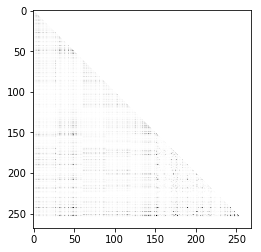

In [11]:
plt.imshow(pairs, cmap="Greys");

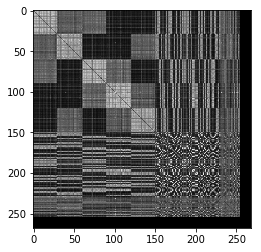

In [12]:
nDrafts = draftCount
prob = pairs*1.0 # Make a copy, and also make symmetric

for i in range(nCards):
    for j in range(i+1):
        if freq[i]>0 and freq[j]>0:
            prob[i,j] = prob[i,j]/float(freq[i])/float(freq[j])*nDrafts
            prob[j,i] = prob[i,j]
        
dist = (1-0.99*prob/prob.max())
plt.imshow(dist, cmap="Greys");

In [13]:
embedding = MDS(n_components=2, dissimilarity='precomputed', max_iter=1000, eps=0.001)
fit = embedding.fit_transform(dist)

In [14]:
# Debugging: a list of cards that weren't drafted, but are in the db
for i in range(nCards):
    if freq[i]==0:
        cardpicks[cardlist[i]].append(100) # Placeholder (they'll be deleted anyway)
        print(cardlist[i])

plains
island
swamp
mountain
forest
dovin_architect_of_law
elite_arrester
dovin's_dismissal
dovin's_automaton
domri_city_smasher
ragefire
charging_war_boar
domri's_nodorog
the_haunt_of_hightower


In [26]:
df = pd.DataFrame({
        'avg' : [np.mean(cardpicks[card]) for card in cardpicks],
        'var' : [np.var(cardpicks[card]) for card in cardpicks],
        'count' : [len(cardpicks[card]) for card in cardpicks],
        'color' : [getCardColor(thisSet[card]) for card in cardpicks],
        'rarity': [thisSet[card]['rarity'] for card in cardpicks],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpicks],
        'x' : fit[:,0],
        'y' : fit[:,1],
        'freq': freq[:]
    }, list(cardpicks.keys()))

# Now some torturous attempt to use proper color names, while retaining their sequence
colorName = {0:"C", 1:"Multi", 2:"W", 3:"U", 4:"B", 5:"R", 6:"G"}
df['color'] = df.color.map(colorName)
from pandas.api.types import CategoricalDtype
ctype = CategoricalDtype(categories=["C","Multi","W","U","B","R","G"],ordered=True)
df['color'] = df['color'].astype(ctype)

df.head()

,avg,var,count,color,rarity,legendary,x,y,freq
angel_of_grace,1.000000,0.000000,902,W,mythic,0,-0.374994,-0.285152,2730
angelic_exaltation,4.704590,6.964518,2549,W,uncommon,0,-0.507103,-0.235531,7394
archway_angel,3.984908,5.089208,1789,W,uncommon,0,-0.418902,-0.346366,5890
arrester's_zeal,8.019244,9.241225,4313,W,common,0,-0.495628,-0.273517,15778
bring_to_trial,7.394884,10.063961,7349,W,common,0,-0.451454,-0.304750,23988


In [70]:
# Manually looking for missing cards (if necessary)

# df.index.values # Full list - ragefire isn't in the main list, but was indeed added at the very end
# df.loc['ragefire'] # Empty record

#for i in range(20): # Look at draft history manually (just in case)
#    print(draftData.iloc[i]['human'])

In [16]:
# Save the data.
# Note, it saves to gitHub-visible folder, not to hidden 'data' folder:

df.to_csv('Arseny/basic_data_'+setName+'.csv', index_label="name")
np.savetxt('Arseny/distances_'+setName+'.csv', dist, delimiter=",")

In [17]:
if len(df)==len(freq):
    df = df[freq>0] # Essential for a reasonable vis below
# (But we cannot do it earlier, as we need to save full data for df and dist to match)

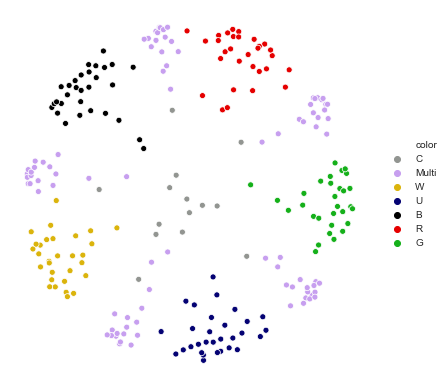

In [22]:
#%matplotlib inline

myPal = sns.xkcd_palette(["grey","lavender","gold","deep blue","black","red","green"])
s = sns.relplot(data=df,x="x",y="y",hue="color",palette=myPal)
s.fig.set_size_inches(7,6)
sns.set_style("white")
s.despine(left=True,bottom=True)
s.set(xticklabels=[],yticklabels=[],xlabel='',ylabel='');

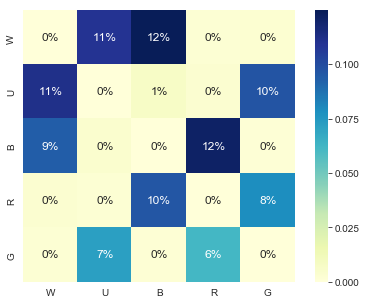

In [23]:
ax = sns.heatmap(guilds/np.sum(guilds), annot=True, fmt="2.0%", cmap="YlGnBu", annot_kws={"size": 12})
ax.set_aspect('equal')
ax.figure.set_size_inches(7,5)
ax.set_xticklabels(["W","U","B","R","G"]); # suppress output, or it returns something
ax.set_yticklabels(["W","U","B","R","G"]); 

In [24]:
# Top picks:
df.sort_values(by=['avg'], ascending=True).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
angel_of_grace,1.000000,0.000000,902,W,mythic,0,-0.374994,-0.285152,2730
skarrgan_hellkite,1.000000,0.000000,873,R,mythic,0,0.274203,0.430038,2492
spawn_of_mayhem,1.000000,0.000000,931,B,mythic,0,-0.278841,0.374413,2592
thrash_threat,1.000887,0.000887,1127,Multi,rare,0,0.432857,0.306990,2872
mesmerizing_benthid,1.001304,0.001302,767,U,mythic,0,0.124631,-0.456478,2443
end-raze_forerunners,1.001604,0.001601,1247,G,rare,0,0.537962,0.016060,3698
biogenic_ooze,1.002220,0.002215,901,G,mythic,0,0.443365,-0.080061,2579
warrant_warden,1.003940,0.003925,1269,Multi,rare,0,-0.212271,-0.525162,2970
incubation_druid,1.004773,0.004750,1257,G,rare,0,0.501318,-0.139354,3759
electrodominance,1.005469,0.005439,1280,R,rare,0,0.208381,0.479490,3715


In [25]:
# Top controversial cards (without correction for 'intrinsic controversy')
df.sort_values(by=['var'], ascending=False).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
kaya_orzhov_usurper,7.556142,18.431290,2841,Multi,mythic,1,-0.228393,0.057174,9533
emergency_powers,9.225240,17.575998,1878,Multi,mythic,0,-0.080810,-0.203192,7008
cindervines,9.100991,17.569219,3129,Multi,rare,0,0.258310,0.176748,11466
smothering_tithe,7.875270,17.315905,2317,W,rare,0,-0.263283,-0.119937,7571
mirror_march,7.863747,16.895304,2055,R,rare,0,0.116233,0.288231,6866
high_alert,7.087882,16.653136,5166,Multi,uncommon,0,-0.228067,-0.463293,13013
absorb,7.259969,16.539184,3812,Multi,rare,0,-0.173756,-0.397749,11008
lavinia_azorius_renegade,9.277665,15.910682,2946,Multi,rare,1,-0.138965,-0.238545,10317
godless_shrine,7.583935,15.191521,4569,Multi,rare,0,-0.363968,0.051514,11049
awaken_the_erstwhile,9.748383,15.175369,1546,B,rare,0,-0.181629,0.184879,6469
